# 1R1C Thermal Model Example
This notebook demonstrates how to use a simple Resistance-Capacitance (RC) thermal model to simulate indoor temperatures and HVAC loads for multiple buildings.

## Imports
Import required libraries and set visualization defaults.

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from entise.core.generator import TimeSeriesGenerator as TSGen
%matplotlib inline

## Load Data
We load building parameters from `objects.csv` and simulation data from the `data` folder.

In [6]:
cwd = '.'  # Current working directory: change if your kernel is not running in the same folder
objects = pd.read_csv(os.path.join(cwd, 'objects.csv'))
data = {}
data_folder = 'data'
for file in os.listdir(os.path.join(cwd, data_folder)):
    if file.endswith('.csv'):
        name = file.split('.')[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, data_folder, file)), parse_dates=True)
print('Loaded data keys:', list(data.keys()))

Loaded data keys: ['internal_gains', 'ventilation', 'weather', 'windows']


## Instantiate and Configure Model
Initialize the time series generator and configure it with building objects.

In [7]:
gen = TSGen()
gen.add_objects(objects)

## Run the Simulation
Generate sequential HVAC load and indoor temperature time series for each building.

In [8]:
summary, df = gen.generate(data, workers=1)

100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


## Results Summary
Below is a summary of the annual heating and cooling demands (in kWh/a) and peak loads (kW).

In [9]:
print("Summary [kWh/a] or [kW/a]:")
summary_kwh = (summary / 1000).round(0).astype(int)
print(summary_kwh)

Summary [kWh/a] or [kW/a]:
          demand_heating  load_max_heating  demand_cooling  load_max_cooling
367791            279855               113           90393               131
31991680          452132               170           19891               102
31991682           24180                10            7645                11
31991685          145169                61           15650                45
31991686           35035                14            6088                12
31991687           61428                23            3896                14
31991688           82218                37            3412                24
31991690           35936                17            4270                15
31991691           30867                11             563                 6


## Visualization of Results
Visualize indoor temperature, heating, and cooling loads for a selected building.

In [10]:
# Select building ID to visualize
building_id = 31991690
building_data = df[building_id]['hvac']
building_data.index = pd.to_datetime(building_data.index)

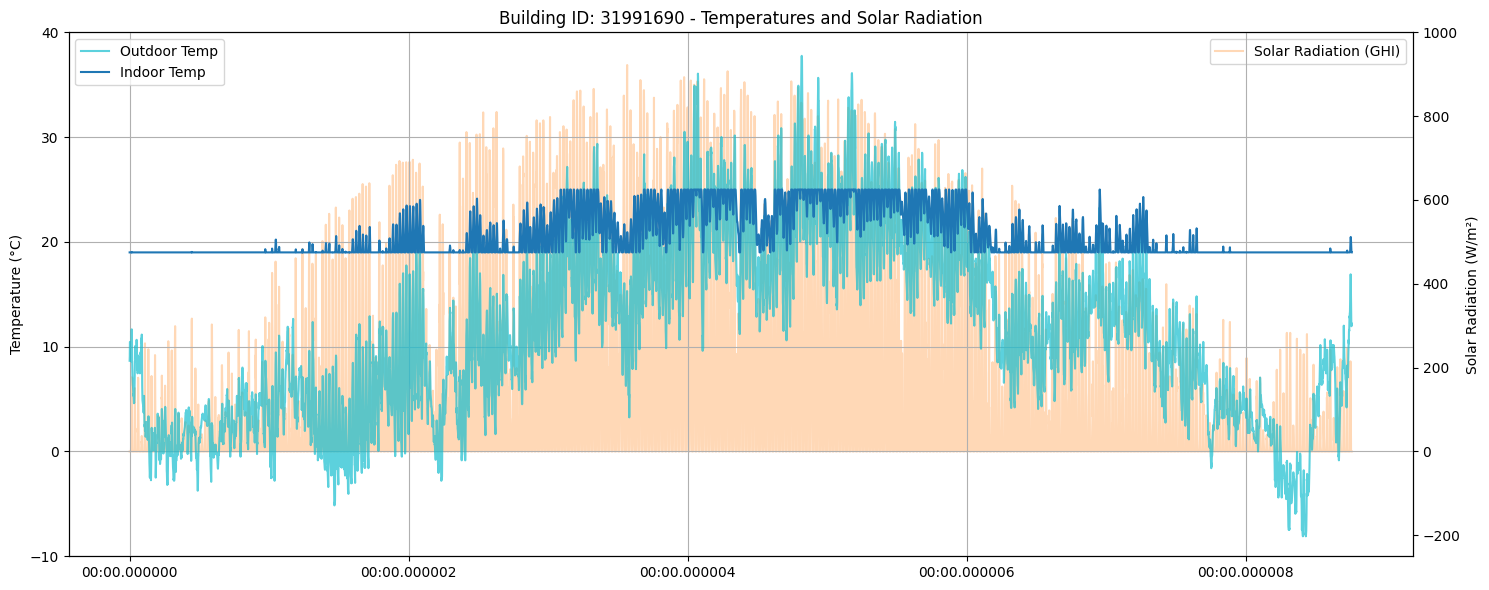

In [11]:
# Figure 1: Indoor & Outdoor Temperature and Solar Radiation (GHI)
fig, ax1 = plt.subplots(figsize=(15, 6))

# Solar radiation plot (GHI) with separate y-axis
ax2 = ax1.twinx()
ax2.plot(building_data.index, data['weather']['solar_ghi'], label='Solar Radiation (GHI)', color='tab:orange', alpha=0.3)
ax2.set_ylabel('Solar Radiation (W/m²)')
ax2.legend(loc='upper right')
ax2.set_ylim(-250, 1000)

# Temperature plot
ax1.plot(building_data.index, data['weather']['temp_out'], label='Outdoor Temp', color='tab:cyan', alpha=0.7)
ax1.plot(building_data.index, building_data['temp_in'], label='Indoor Temp', color='tab:blue')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title(f'Building ID: {building_id} - Temperatures and Solar Radiation')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.set_ylim(-10, 40)

ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)  # required to see through ax1 to ax2
plt.tight_layout()
plt.show()

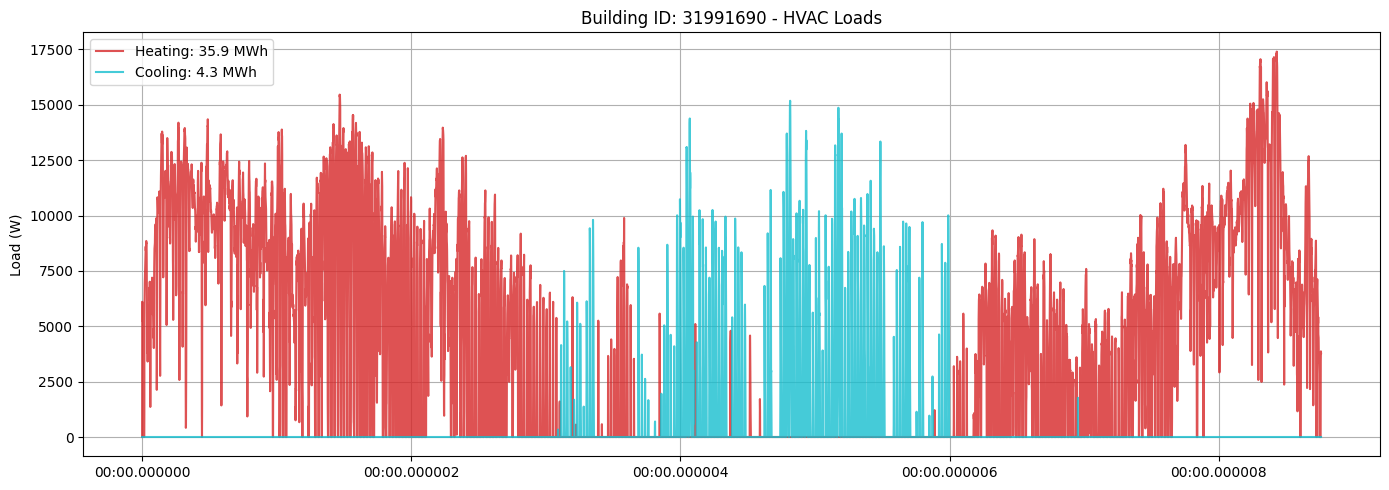

In [12]:
# Figure 2: Heating and Cooling Loads
fig, ax = plt.subplots(figsize=(14, 5))
heating_MWh = summary.loc[building_id, 'demand_heating'] / 1e6
cooling_MWh = summary.loc[building_id, 'demand_cooling'] / 1e6
line1, = ax.plot(building_data.index, building_data['load_heating'],
                 label=f"Heating: {heating_MWh:.1f} MWh", color='tab:red', alpha=0.8)
line2, = ax.plot(building_data.index, building_data['load_cooling'],
                 label=f"Cooling: {cooling_MWh:.1f} MWh", color='tab:cyan', alpha=0.8)
# Create the combined legend in the upper left corner
ax.set_ylabel('Load (W)')
ax.set_title(f'Building ID: {building_id} - HVAC Loads')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


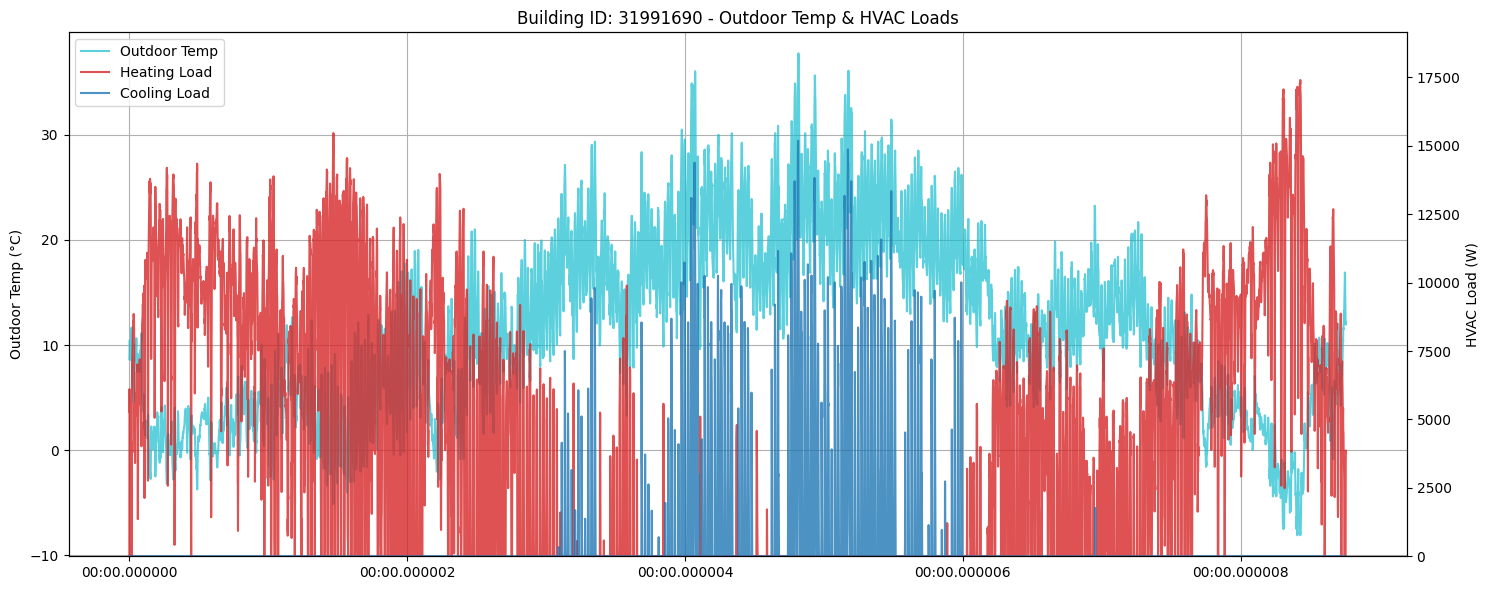

In [13]:
# Figure 3: Outdoor Temperature with Heating & Cooling Loads
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot outdoor temperature on left y-axis
ax1.plot(building_data.index,data['weather']['temp_out'],label='Outdoor Temp',color='tab:cyan',alpha=0.7)

ax1.set_ylabel('Outdoor Temp (°C)')
ax1.set_ylim(data['weather']['temp_out'].min() - 2, data['weather']['temp_out'].max() + 2)

# Create second y-axis for loads
ax2 = ax1.twinx()
ax2.plot(building_data.index, building_data['load_heating'], label='Heating Load', color='tab:red', alpha=0.8)
ax2.plot(building_data.index, building_data['load_cooling'], label='Cooling Load', color='tab:blue', alpha=0.8)
ax2.set_ylabel('HVAC Load (W)')
ax2.set_ylim(
    min(building_data['load_heating'].min(), building_data['load_cooling'].min()) * 1.1,
    max(building_data['load_heating'].max(), building_data['load_cooling'].max()) * 1.1
)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title(f'Building ID: {building_id} - Outdoor Temp & HVAC Loads')
ax1.grid(True)
fig.tight_layout()
plt.show()

## Next Steps
You can further explore:
- Adjusting building parameters in `objects.csv`
- Incorporating or excluding additional data (e.g., internal gains, solar gains)
- Investigate how different ventilation strategies impact a buildings energy demand (ventilation)
- Automating analysis for larger building datasets